<a href="https://colab.research.google.com/github/ss-ghule/misc_or_test_repo/blob/master/my_first_gan_mnist_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN







In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0-beta1'

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## Load Data

In [7]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


5

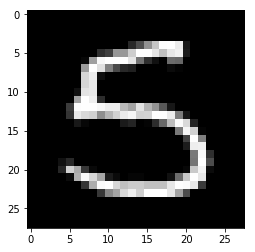

In [16]:
num=np.random.randint(0,60000)
plt.imshow(train_images[num],cmap='gray')
train_labels[num]

In [17]:
type(train_images[num])

numpy.ndarray

In [22]:
print(train_images.min())
print(train_images.max())

-1.0
1.0


In [0]:
train_images=train_images.reshape(train_images.shape[0],28,28,1)
train_images=(train_images - 127.5)/127.5

In [23]:
print(train_images[num].min())
print(train_images[num].max())

-1.0
1.0


In [0]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [0]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [0]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

  return model

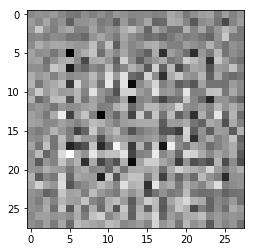

In [31]:
generator=make_generator_model()
noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

## Discriminator

In [0]:
def make_discriminator_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',
                          input_shape=[28,28,1]))
  
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [33]:
discriminator=make_discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00218777]], shape=(1, 1), dtype=float32)


## Loss and Optimizers

In [0]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [0]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [0]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

In [45]:
checkpoint_prefix

'./training_checkpoints/ckpt'

## Training loop Definition

In [0]:
EPOCHS=50
noise_dim=100
num_example_to_generate=16
seed=tf.random.normal([num_example_to_generate,noise_dim])

In [41]:
seed

<tf.Tensor: id=853, shape=(16, 100), dtype=float32, numpy=
array([[-0.8215403 ,  0.6120837 ,  0.09707946, ..., -0.36463475,
         1.4389105 , -0.7671734 ],
       [ 0.4591619 , -0.3131607 ,  0.54949003, ..., -1.6566796 ,
        -0.07954712,  0.38506916],
       [ 0.03607626, -0.8448886 , -0.00688584, ...,  0.41445187,
         1.0876862 ,  0.95441765],
       ...,
       [-0.2633116 , -0.0065573 ,  2.0473776 , ...,  1.2170104 ,
        -2.2448316 , -0.67827666],
       [-0.10267603,  1.0276346 , -0.2021033 , ...,  1.3104378 ,
        -0.6566664 , -0.72311115],
       [ 0.28352526,  0.26683   ,  1.2601869 , ...,  0.4870425 ,
         0.04098208, -1.0828592 ]], dtype=float32)>

In [0]:
@tf.function
def train_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    images=tf.cast(images,tf.float32)
    generated_images=tf.cast(generated_images,tf.float32)
    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)

  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [0]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)

    if (epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [0]:
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training

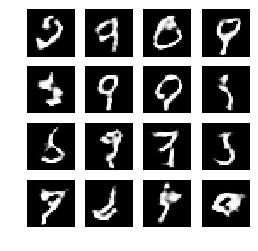

CPU times: user 4min 50s, sys: 1min 28s, total: 6min 19s
Wall time: 20min 25s


In [73]:
%%time
train(train_dataset,EPOCHS)

In [74]:
!ls

100.jpg  19.jpg  51.jpg  84.jpg			  image_at_epoch_0019.png
101.jpg  1.jpg	 52.jpg  85.jpg			  image_at_epoch_0020.png
102.jpg  20.jpg  53.jpg  86.jpg			  image_at_epoch_0021.png
103.jpg  21.jpg  54.jpg  87.jpg			  image_at_epoch_0022.png
104.jpg  22.jpg  55.jpg  88.jpg			  image_at_epoch_0023.png
105.jpg  23.jpg  56.jpg  89.jpg			  image_at_epoch_0024.png
106.jpg  24.jpg  57.jpg  8.jpg			  image_at_epoch_0025.png
107.jpg  25.jpg  58.jpg  90.jpg			  image_at_epoch_0026.png
108.jpg  26.jpg  59.jpg  91.jpg			  image_at_epoch_0027.png
109.jpg  27.jpg  5.jpg	 92.jpg			  image_at_epoch_0028.png
10.jpg	 28.jpg  60.jpg  93.jpg			  image_at_epoch_0029.png
110.jpg  29.jpg  61.jpg  94.jpg			  image_at_epoch_0030.png
111.jpg  2.jpg	 62.jpg  95.jpg			  image_at_epoch_0031.png
112.jpg  30.jpg  63.jpg  96.jpg			  image_at_epoch_0032.png
113.jpg  31.jpg  64.jpg  97.jpg			  image_at_epoch_0033.png
114.jpg  32.jpg  65.jpg  98.jpg			  image_at_epoch_0034.png
115.jpg  33.jpg  66.jpg  99.jpg			  image_at_

In [0]:
from PIL import Image

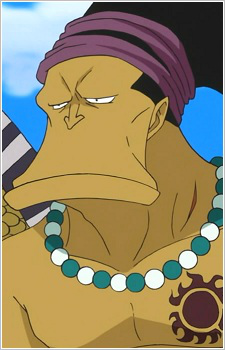

In [81]:
img=Image.open('501.jpg')
display.display(img)